<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/4.multilayer_perceptrons/4_5_weight_decay_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [95]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [96]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

In [97]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

In [98]:
def init_params():
  
  w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
  b = tf.Variable(tf.zeros(shape=(1,)))
  return [w, b]

In [99]:
def l2_penalty(w):
  return tf.reduce_sum(tf.pow(w, 2)) / 2

In [100]:
def linreg(X, w, b):
    """The linear regression model."""
    return tf.matmul(X, w) + b

In [101]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

In [102]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

In [103]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [104]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), tf.size(l))
    return metric[0] / metric[1]

In [105]:
def train(lambd):
  w, b = init_params()
  net, loss = lambda X: linreg(X, w, b), squared_loss
  num_epochs, lr = 100, 0.003

  x = []
  train_loss = []
  test_loss = []
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with tf.GradientTape() as tape:
          l = loss(net(X), y) + lambd * l2_penalty(w)
      grads = tape.gradient(l, [w, b])
      sgd([w, b], grads, lr, batch_size)
    if (epoch + 1) % 5 == 0:
      x.append(epoch)
      train_loss.append(evaluate_loss(net, train_iter, loss))
      test_loss.append(evaluate_loss(net, test_iter, loss))
  plt.plot(x, train_loss, 'r')
  plt.plot(x, test_loss, 'b')
  plt.show()

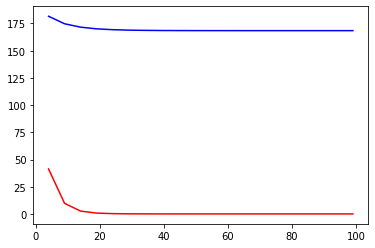

In [106]:
train(lambd=0)

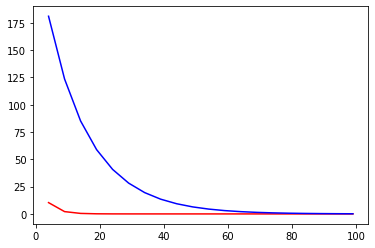

In [107]:
train(lambd=3)

In [108]:
def train_concise(wd):
   net = tf.keras.models.Sequential()
   net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(wd)))
   net.build(input_shape=(1, num_inputs))
   w, b = net.trainable_variables
   loss = tf.keras.losses.MeanSquaredError()
   num_epochs, lr = 100, 0.003
   trainer = tf.keras.optimizers.SGD(learning_rate=lr)

   x = []
   train_loss = []
   test_loss = []
   for epoch in range(num_epochs):
     for X, y in train_iter:
       with tf.GradientTape() as tape:
         l = loss(net(X), y) + net.losses
       grads = tape.gradient(l, net.trainable_variables)
       trainer.apply_gradients(zip(grads, net.trainable_variables))
     if (epoch + 1) % 5 == 0:
       x.append(epoch)
       train_loss.append(evaluate_loss(net, train_iter, loss))
       test_loss.append(evaluate_loss(net, test_iter, loss))
   plt.plot(x, train_loss, 'r')
   plt.plot(x, test_loss, 'b')
   plt.show()

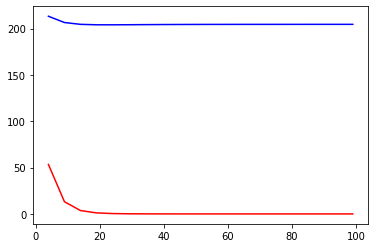

In [109]:
train(lambd=0)

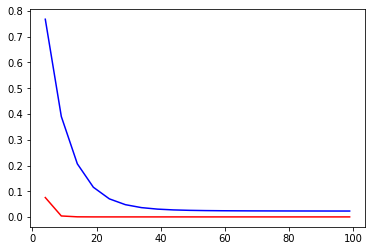

In [110]:
train_concise(3)